In [1]:
!python --version

Python 3.9.7


In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve

In [3]:
test_unseen=pd.read_json('annotations/test_unseen.jsonl',lines=True)
predict_test_unseen=pd.read_csv("ens0507_test_unseen_SA.csv")

In [19]:
predict=pd.read_csv('ens1009_test_unseen_SA.csv')

In [4]:
test_unseen[(predict_test_unseen['label'] == test_unseen['label'])== True]

,id,img,label,text
0,15740,img/15740.png,1,when someone tells you how to bbq
1,38794,img/38794.png,1,when they say white folks don't know how to cook
3,71824,img/71824.png,1,okay here you go! you piece of shit!
4,4796,img/04796.png,1,xboxone farming 1619 simulator
5,75310,img/75310.png,1,how roaches be when you shut off the kitchen l...
...,...,...,...,...
1995,71352,img/71352.png,0,fighting for gay rights
1996,2164,img/02164.png,0,that feeling when you finish your homework in ...
1997,3587,img/03587.png,0,the day that shook new york city
1998,47839,img/47839.png,0,one of the first prototypes of the atom bomb


In [9]:
pred = predict_test_unseen['label']
real = test_unseen['label']
cm_terms=[]
for i, label in enumerate(pred):
    if label == real[i]:
        if label == 1:
            cm_terms.append('TP')
        elif label == 0:
            cm_terms.append('TN')
        else:
            cm_terms.append('error')
        
    elif label != real[i]:
        if label == 1:
            cm_terms.append('FN')
        elif label == 0:
            cm_terms.append('FP')
        else:
            cm_terms.append('error')

In [11]:
pd.concat([test_unseen['label'], predict_test_unseen['label']], axis=1).rename(columns={'label': 'real'})

,real,real
0,1,1
1,1,1
2,1,0
3,1,1
4,1,1
...,...,...
1995,0,0
1996,0,0
1997,0,0
1998,0,0


In [45]:
def norm(data):
    norm_data =  (data - np.min(data)) / (np.max(data) - np.min(data))
    return norm_data

def conf_matrx_termenology(ids, real, pred, proba):
    cm_terms=[]
    for i, label in enumerate(pred):
        if label == real[i]:
            if label == 1:
                cm_terms.append('TP')
            elif label == 0:
                cm_terms.append('TN')
            else:
                cm_terms.append('error')

        elif label != real[i]:
            if label == 1:
                cm_terms.append('FP')
            elif label == 0:
                cm_terms.append('FN')
            else:
                cm_terms.append('error')
    # transform to df
    ids = pd.DataFrame(ids)
    real=pd.DataFrame(real).rename(columns={'label': 'real'})
    pred=pd.DataFrame(pred).rename(columns={'label':'predicted'})
    cm_terms=pd.DataFrame(cm_terms).rename(columns={0:'class'})
    result=pd.concat([ids, real, pred, cm_terms, norm(proba)], axis=1)
    return result

In [46]:
conf_matrx_termenology(test_unseen['id'], 
                       test_unseen['label'], 
                       predict['label'],
                      predict['proba']).to_csv("reults_with_cmv2.csv", index=False)

## Normalize prob [0,1]

In [29]:
def norm(data):
    norm_data =  (data - np.min(data)) / (np.max(data) - np.min(data))
    return norm_data

In [42]:
roc_auc_score(test_unseen['label'], norm(predict['proba']))

0.8276341333333332

In [43]:
norm(predict['proba'])

0       0.432846
1       0.852893
2       0.316704
3       0.288843
4       0.745172
          ...   
1995    0.124828
1996    0.068516
1997    0.049027
1998    0.146421
1999    0.049169
Name: proba, Length: 2000, dtype: float64

In [38]:
sum(pd.DataFrame(norm(predict['proba']))['label'] == test_unseen['label'])

1536

In [39]:
1536/2000

0.768

In [25]:
predict['proba'].max()

6.029936630718804

In [26]:
predict['proba'].min()

-6.258200409266134

In [20]:
roc_auc_score(test_unseen['label'], predict['proba'])

0.8276341333333332

In [40]:
accuracy_score(test_unseen['label'], predict['label'])

0.768

## Plots for distr Proba

In [50]:
import matplotlib as plt
import seaborn as sns

In [51]:
predict_cm=conf_matrx_termenology(test_unseen['id'], 
                       test_unseen['label'], 
                       predict['label'],
                      predict['proba'])

In [52]:
predict_cm

,id,real,predicted,class,proba
0,15740,1,1,TP,0.432846
1,38794,1,1,TP,0.852893
2,60792,1,0,FN,0.316704
3,71824,1,0,FN,0.288843
4,4796,1,1,TP,0.745172
...,...,...,...,...,...
1995,71352,0,0,TN,0.124828
1996,2164,0,0,TN,0.068516
1997,3587,0,0,TN,0.049027
1998,47839,0,0,TN,0.146421


<AxesSubplot:xlabel='proba', ylabel='class'>

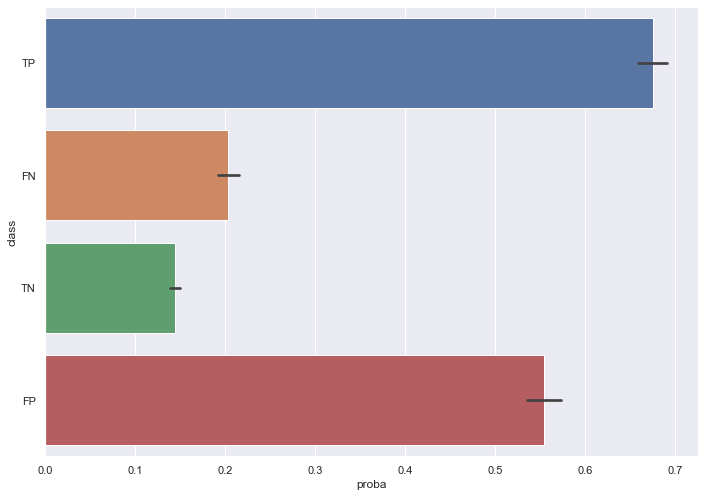

In [54]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='proba', y='class', orient = "h", data=predict_cm)

In [89]:
import matplotlib.pyplot as plt

Text(0, 0.5, '')

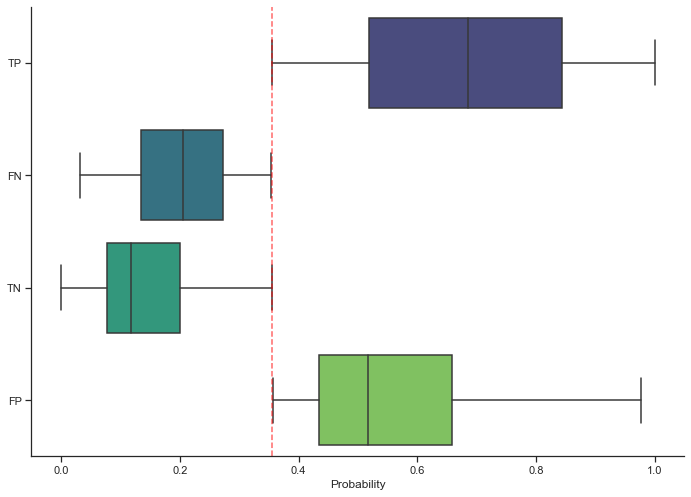

In [115]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.color_palette("viridis", as_cmap=True)
ax=sns.boxplot(x='proba', y='class', orient = "h", data=predict_cm,
           palette='viridis')
ax.axvline(0.35610683508344143, ls ='--',
          alpha=0.6,
          color='red')
ax.set_title("")
ax.set_xlabel("Probability")
ax.set_ylabel("")

### Best treshold

In [86]:
from sklearn import metrics

def get_acc_and_best_threshold_from_roc_curve_(org_file, ens_file):
    fpr, tpr, thresholds = metrics.roc_curve(org_file['label'], ens_file['proba'],  pos_label=1)
    num_pos_class, num_neg_class = len(ens_file['predicted'] == 1), len(ens_file['predicted'] == 0)

    tp = tpr * num_pos_class
    tn = (1 - fpr) * num_neg_class
    acc = (tp + tn) / (num_pos_class + num_neg_class)

    best_threshold = thresholds[np.argmax(acc)]

    return best_threshold

In [87]:
get_acc_and_best_threshold_from_roc_curve_(test_unseen, predict_cm)

0.35610683508344143

# Which have hight error by Error type

#### TP

In [129]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'TP']['proba'].min()]

,id,real,predicted,class,proba
124,32149,1,1,TP,0.356107


In [128]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'TP']['proba'].max()]

,id,real,predicted,class,proba
311,59420,1,1,TP,1.0


In [152]:
FP_mean=predict_cm[predict_cm['class'] == 'TP']['proba'].mean()

predict_cm[predict_cm['class'] == 'TP'][(predict_cm.proba > FP_mean-0.001) & 
           (predict_cm.proba < FP_mean+0.001)]

/var/folders/pv/21djj0qj50v927yf9fbqsnsh0000gn/T/ipykernel_75161/245542961.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predict_cm[predict_cm['class'] == 'TP'][(predict_cm.proba > FP_mean-0.001) &


,id,real,predicted,class,proba
30,51379,1,1,TP,0.676828
246,14896,1,1,TP,0.676790
368,20341,1,1,TP,0.676617
421,21683,1,1,TP,0.676897


#### TN

In [130]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'TN']['proba'].min()]

,id,real,predicted,class,proba
1037,8374,0,0,TN,0.0


In [ ]:
#### predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'TN']['proba'].max()]

In [151]:
FP_mean=predict_cm[predict_cm['class'] == 'TN']['proba'].mean()

predict_cm[predict_cm['class'] == 'TN'][(predict_cm.proba > FP_mean-0.001) & 
           (predict_cm.proba < FP_mean+0.001)]

/var/folders/pv/21djj0qj50v927yf9fbqsnsh0000gn/T/ipykernel_75161/1173211477.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predict_cm[predict_cm['class'] == 'TN'][(predict_cm.proba > FP_mean-0.001) &


,id,real,predicted,class,proba
948,27958,0,0,TN,0.144941
974,28541,0,0,TN,0.143842
1044,3926,0,0,TN,0.144843
1057,67598,0,0,TN,0.143260
1142,57382,0,0,TN,0.143727
1204,29473,0,0,TN,0.144414
1362,26348,0,0,TN,0.144629
1701,40376,0,0,TN,0.144196
1865,71805,0,0,TN,0.143975


#### FP

In [131]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'FP']['proba'].min()]

,id,real,predicted,class,proba
1954,37469,0,1,FP,0.356488


In [164]:
test_unseen[test_unseen['id'] == 37690]

,id,img,label,text
1785,37690,img/37690.png,0,congratulations it's non binary


In [132]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'FP']['proba'].max()]

,id,real,predicted,class,proba
1254,2149,0,1,FP,0.977119


In [161]:
test_unseen[test_unseen['id'] == 2149]

,id,img,label,text
1254,2149,img/02149.png,0,what's that burning? oh it's my pot roast


In [148]:
FP_mean=predict_cm[predict_cm['class'] == 'FP']['proba'].mean()

predict_cm[predict_cm['class'] == 'FP'][(predict_cm.proba > FP_mean-0.001) & 
           (predict_cm.proba < FP_mean+0.001)]

/var/folders/pv/21djj0qj50v927yf9fbqsnsh0000gn/T/ipykernel_75161/157439190.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predict_cm[predict_cm['class'] == 'FP'][(predict_cm.proba > FP_mean-0.001) &


,id,real,predicted,class,proba
1785,37690,0,1,FP,0.55493


#### FN

In [154]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'FN']['proba'].min()]

,id,real,predicted,class,proba
287,12930,1,0,FN,0.031301


In [153]:
predict_cm[predict_cm['proba']==predict_cm[predict_cm['class'] == 'FN']['proba'].max()]

,id,real,predicted,class,proba
499,21036,1,0,FN,0.353285


In [156]:
FP_mean=predict_cm[predict_cm['class'] == 'FN']['proba'].mean()

predict_cm[predict_cm['class'] == 'FN'][(predict_cm.proba > FP_mean-0.001) & 
           (predict_cm.proba < FP_mean+0.01)]

/var/folders/pv/21djj0qj50v927yf9fbqsnsh0000gn/T/ipykernel_75161/1291546606.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predict_cm[predict_cm['class'] == 'FN'][(predict_cm.proba > FP_mean-0.001) &


,id,real,predicted,class,proba
59,42609,1,0,FN,0.208130
79,32904,1,0,FN,0.205054
337,60714,1,0,FN,0.206418
